# Sharing Optimization - SVM parallel

In [2]:
import numpy as np
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, Normalizer

from utils import *

### Breast Cancer dataset

In [ ]:
X_train, X_test, y_train, y_test = load_breast_test_train_dataset()

In [ ]:
sum(y_train)

In [ ]:
sum(y_test)

### Loan Clients dataset

In [3]:
X_train, X_test, y_train, y_test = load_Loan_test_train_dataset()

### Normalize data

In [4]:
normalizer_ = Normalizer()
normalizer_.fit(X_train)

X_train = normalizer_.transform(X_train)
X_test = normalizer_.transform(X_test)

In [4]:
# X_train.shape

In [5]:
# scaler = StandardScaler()
# scaler.fit(X_train)

# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

## Parallel Sharing-based SVM

### **Divide data into blocks - splitting across features**

In [5]:
def get_feature_chunks(A, x, n):
    """
    Split data by columns.
    
    n - the number of columns in a chunk.
        When data cannot be divided into chunks of the same length,
        a last chunk will be uncomplete.
    """
    sections = range(0, A.shape[1], n)[1:]
    A_chunks = np.hsplit(A, sections)
    x_chunks = np.hsplit(x, sections)
    return A_chunks, x_chunks

In [6]:
def generate_A_mat(X, y):
    """
    Generates the A matrix for parallel SVM.
    
    X is a matrix of shape (N x m);
    y is a vector of length N;
    A is a matrix of shape (N x (m+1));
    A = [a1 a2 ... ai ... aN].T,  
    where ai = [-yi*xi -yi]
    """
    # Add one at the end of all x-data vectors
    X = np.concatenate((X, np.ones((X.shape[0], 1))), axis = 1)
    
    # -1 * y_vector
    minus_y = np.multiply(-1, y).reshape(-1, 1)
    
    # Componentiwise multiplication
    A = np.multiply(minus_y, X)
    return A

In [7]:
def get_accuracies(y_pred_tr, y_pred_te):
    train_acc = accuracy_score(y_train, y_pred_tr)
    test_acc = accuracy_score(y_test, y_pred_te)
    
    return train_acc, test_acc

### ADMM

In [8]:
class Node():
    
    def __init__(self, A_chunk, x, rho, lamb, id_num):
        self.A = A_chunk
        self.x = x.reshape(-1,1)
        self.rho = rho
        self.lamb = lamb
        self.number = id_num
    
    def compute_x_i(self, u, z, mean_Ax):
        mean_Ax = mean_Ax.reshape(-1,1)
        const = 2*self.lamb/self.rho
        AA = self.A.T.dot(self.A)
        part1 = np.linalg.inv(const*np.identity(AA.shape[0]) + AA)
        
        Ax = self.A.dot(self.x)
        z = z.reshape(-1,1)
        u = u.reshape(-1,1)
        part2 = self.A.T.dot(Ax - mean_Ax + z - u)
        
        self.x = part1.dot(part2)


In [110]:
class FusionCenter():
    
    def __init__(self, N, rho, lamb, A_chunks, x_chunks, nodes):
        self.N = N # number of chunks
        self.rho = rho
        self.lamb = lamb
        self.A_chunks = A_chunks
        self.x_chunks = x_chunks
        self.nodes = nodes #to observe all Node instances
        self.m = self.A_chunks[0].shape[0] #number of data points
    
    def collect_x(self):
        """ Collect x_chunk from every Node"""
        self.old_x_chunks = self.x_chunks.copy()
        self.x_chunks = [node.x for node in self.nodes]


    def _average_Ax(self):
        """ Calculate all Ai*xi and 
            return the componentwise average"""
        
        Ax_all = np.zeros((self.m, self.N))

        for idx, A in enumerate(self.A_chunks):
            x = np.array(self.x_chunks[idx]).reshape(-1,1)
            Ax_all[:, idx] = A.dot(x).T

        return np.average(Ax_all, axis=1).reshape(-1,1)

    def compute_z(self, u=None):
        self.Ax_bar = self._average_Ax()
        
        if u is None:
            u = self.u.copy()
        else:
            self.z = np.zeros((self.m,1))
            return

#         self.Ax_bar = self._average_Ax()
        v = self.Ax_bar + u
#         print(v)
        self.z = np.zeros((self.m,1))
        
        for idx, vi in enumerate(v):
            if vi > 1/self.rho - (1/self.N):
                self.z[idx] = vi - 1/self.rho
#                 self.z[idx] = vi - self.N/self.rho
                
            elif vi < -1/self.N:
                self.z[idx] = vi
            
            else:
                self.z[idx] = -1/self.N
#             print('v {} z {}'.format(vi, self.z[idx]))
    
    def compute_u(self, u=None):
        if u is None:
            u = self.u
            self.u = u + self.Ax_bar - self.z
        else:
            self.u = u + self.Ax_bar - self.z
        
#     def check_convergence(self, error_tol):
#         for i in range(self.N):
#             Ax = self.A_chunks[i].dot(self.x_chunks[i])
#             diff = Ax - self.z 
#             print(diff[0], Ax[0], self.z[0], self.u[0])
# #             print(Ax[:1], self.z[:1])
# #             print(sum(abs(diff)))
#             if (abs(diff) > error_tol).any():
#                 return False
#             else:
#                 return True

    def check_convergence(self, error_tol):
        old = np.concatenate(self.old_x_chunks)
        new = np.concatenate(self.x_chunks)
        print(abs(old - new)[:2])
        if (abs(old - new) > error_tol).any():
            return False
        else:
            return True

### def __main__:

In [142]:
# Fixed parameters:

RHO = 2.5 #2.5#0.1
LAMBD = 10
E_TOL = 0.00001

In [143]:
1/RHO# - (1/4)

0.4

In [144]:
# Initialization:

m, n = X_train.shape
z_init = np.zeros((m,1))
u_init = np.zeros((m,1))
x_init = np.zeros(n+1)

mean_Ax_init = np.zeros((m,1))

In [145]:
# Generate data blocks:

A_train = generate_A_mat(X_train, y_train)
A_test = generate_A_mat(X_test, y_test)
A_chunks, x_chunks = get_feature_chunks(A_train, x_init, int(np.ceil(n/4)))

N = len(A_chunks)

In [146]:
for ch in A_chunks:
    print(ch.shape)

(21934, 13)
(21934, 13)
(21934, 13)
(21934, 12)


####  First iteration:

In [147]:
node1 = Node(A_chunk=A_chunks[0], x=x_chunks[0], #mean_Ax=mean_Ax_init,
             rho = RHO, lamb=LAMBD, id_num=0)
node2 = Node(A_chunk=A_chunks[1], x=x_chunks[1], #mean_Ax=mean_Ax_init,
             rho = RHO, lamb=LAMBD, id_num=1)
node3 = Node(A_chunk=A_chunks[2], x=x_chunks[2], #mean_Ax=mean_Ax_init,
             rho = RHO, lamb=LAMBD, id_num=2)
node4 = Node(A_chunk=A_chunks[3], x=x_chunks[3], #mean_Ax=mean_Ax_init,
             rho = RHO, lamb=LAMBD, id_num=3)

FC = FusionCenter(N=N, rho=RHO, lamb=LAMBD,
                  A_chunks = A_chunks,
                  x_chunks = x_chunks,
                  nodes = [node1, node2, node3, node4])

############################################################

node1.compute_x_i(u = u_init, z = z_init, mean_Ax = mean_Ax_init)
node2.compute_x_i(u = u_init, z = z_init, mean_Ax = mean_Ax_init)
node3.compute_x_i(u = u_init, z = z_init, mean_Ax = mean_Ax_init)
node4.compute_x_i(u = u_init, z = z_init, mean_Ax = mean_Ax_init)

FC.collect_x()

history_acc = []
y_pred_tr = np.sign(A_train.dot(np.concatenate(FC.x_chunks)))
y_pred_te = np.sign(A_test.dot(np.concatenate(FC.x_chunks)))
train_acc, test_acc = get_accuracies(y_pred_tr, y_pred_te)
history_acc.append((train_acc, test_acc))
# print(z_init)
FC.compute_z(u = u_init)
FC.compute_u(u = u_init)
# print(FC.z)

In [148]:
history_acc

[(0.0, 0.0)]

#### More iterations

In [149]:
stop=False
counter = 1

while not stop:
    counter += 1
    print(counter, end=' ')
      
    node1.compute_x_i(u = FC.u, z = FC.z, mean_Ax = FC.Ax_bar)
    node2.compute_x_i(u = FC.u, z = FC.z, mean_Ax = FC.Ax_bar)
    node3.compute_x_i(u = FC.u, z = FC.z, mean_Ax = FC.Ax_bar)
    node4.compute_x_i(u = FC.u, z = FC.z, mean_Ax = FC.Ax_bar)
    
    FC.collect_x()
    
    
    stop = FC.check_convergence(error_tol=E_TOL)
    if counter==2:
        stop=False
    
    ########### SAVE SOME INTERMEDIATE RESULTS
    
#     y_pred_tr, y_pred_te = traintest_predict(x = np.concatenate(FC.x_chunks))
    y_pred_tr = np.sign(A_train.dot(np.concatenate(FC.x_chunks)))
    y_pred_te = np.sign(A_test.dot(np.concatenate(FC.x_chunks)))
    
    train_acc, test_acc = get_accuracies(y_pred_tr, y_pred_te)
    history_acc.append((train_acc, test_acc))


    FC.compute_z()
#     print(FC.z, end="\n\n")
    FC.compute_u()
#     print(FC.u)
#     stop = FC.check_convergence(error_tol=E_TOL)

2 [[0.]
 [0.]]
3 [[0.95872141]
 [1.21167785]]
4 [[0.51096526]
 [0.19069047]]
5 [[0.00596879]
 [0.23928364]]
6 [[0.4045673 ]
 [0.27911758]]
7 [[0.42480347]
 [0.28441787]]
8 [[0.30241335]
 [0.17015174]]
9 [[0.1789425]
 [0.0720246]]
10 [[0.10209791]
 [0.02468217]]
11 [[0.05289313]
 [0.00394187]]
12 [[0.01732479]
 [0.00154316]]
13 [[0.01258371]
 [0.01146156]]
14 [[0.02577081]
 [0.02660372]]
15 [[0.03768206]
 [0.03578164]]
16 [[0.04016798]
 [0.03361153]]
17 [[0.03505523]
 [0.02796899]]
18 [[0.02524771]
 [0.02143593]]
19 [[0.01482353]
 [0.01546804]]
20 [[0.00604573]
 [0.01107589]]
21 [[0.00059253]
 [0.00859528]]
22 [[0.00530683]
 [0.00759885]]
23 [[0.00848211]
 [0.0074676 ]]
24 [[0.01066551]
 [0.00700665]]
25 [[0.01246818]
 [0.00640835]]
26 [[0.01379175]
 [0.00544644]]
27 [[0.01458415]
 [0.00466532]]
28 [[0.01529425]
 [0.00387237]]
29 [[0.01532511]
 [0.00332381]]
30 [[0.01515487]
 [0.00265133]]
31 [[0.01512739]
 [0.00219799]]
32 [[0.01415896]
 [0.00160013]]
33 [[0.01276899]
 [0.00155953]]
34

236 [[0.00019421]
 [0.00010708]]
237 [[0.0002011 ]
 [0.00010721]]
238 [[0.00020556]
 [0.00010729]]
239 [[0.00021277]
 [0.00010564]]
240 [[0.00021363]
 [0.0001017 ]]
241 [[0.00021301]
 [0.0001038 ]]
242 [[0.00021341]
 [0.00010641]]
243 [[0.00020806]
 [0.00010792]]
244 [[0.00020655]
 [0.00010628]]
245 [[0.00020205]
 [0.00010572]]
246 [[0.0001978 ]
 [0.00010077]]
247 [[2.06213004e-04]
 [9.19631480e-05]]
248 [[2.01126162e-04]
 [9.95355752e-05]]
249 [[0.00018994]
 [0.00010033]]
250 [[0.00018204]
 [0.0001014 ]]
251 [[0.00017154]
 [0.00010193]]
252 [[0.00016441]
 [0.00010281]]
253 [[0.00015794]
 [0.0001066 ]]
254 [[0.00015163]
 [0.00010782]]
255 [[0.00014756]
 [0.00010423]]
256 [[0.00014621]
 [0.00010638]]
257 [[0.00014292]
 [0.00010643]]
258 [[0.0001405]
 [0.0001101]]
259 [[0.0001395 ]
 [0.00011134]]
260 [[0.00014146]
 [0.00011353]]
261 [[0.00014002]
 [0.00011306]]
262 [[0.00013979]
 [0.0001139 ]]
263 [[0.00014038]
 [0.00011414]]
264 [[0.00014001]
 [0.00011119]]
265 [[0.00013888]
 [0.0001130

464 [[4.74390189e-05]
 [2.43174839e-04]]
465 [[4.44845175e-05]
 [2.42656710e-04]]
466 [[3.63124027e-05]
 [2.42529236e-04]]
467 [[3.15805594e-05]
 [2.41768249e-04]]
468 [[2.89244028e-05]
 [2.40486097e-04]]
469 [[2.27448947e-05]
 [2.39395468e-04]]
470 [[1.86955784e-05]
 [2.41710987e-04]]
471 [[1.63111021e-05]
 [2.44379707e-04]]
472 [[1.51667908e-05]
 [2.45583701e-04]]
473 [[1.23036874e-05]
 [2.48982861e-04]]
474 [[1.28836558e-05]
 [2.49095325e-04]]
475 [[1.32705742e-05]
 [2.50542998e-04]]
476 [[1.33972390e-05]
 [2.47139064e-04]]
477 [[1.04869996e-05]
 [2.49864613e-04]]
478 [[5.92460732e-05]
 [2.49216010e-04]]
479 [[7.42019244e-05]
 [2.57276053e-04]]
480 [[7.97815491e-05]
 [2.60301857e-04]]
481 [[8.91683360e-05]
 [2.60748509e-04]]
482 [[9.38783156e-05]
 [2.63779266e-04]]
483 [[9.73728765e-05]
 [2.65349114e-04]]
484 [[0.00010152]
 [0.00025649]]
485 [[0.00010152]
 [0.00026146]]
486 [[0.00010359]
 [0.00026257]]
487 [[0.00010862]
 [0.00026344]]
488 [[0.00011008]
 [0.00026596]]
489 [[0.0001108

670 [[2.78909896e-05]
 [1.87332576e-04]]
671 [[3.59425199e-05]
 [1.87983391e-04]]
672 [[3.77112142e-05]
 [1.83024418e-04]]
673 [[3.61557688e-05]
 [1.79539791e-04]]
674 [[3.27210867e-05]
 [1.78229903e-04]]
675 [[2.92762835e-05]
 [1.77172375e-04]]
676 [[2.57853205e-05]
 [1.95263996e-04]]
677 [[1.20656277e-05]
 [1.80826537e-04]]
678 [[7.31279991e-06]
 [1.73070182e-04]]
679 [[4.97810814e-06]
 [1.78590782e-04]]
680 [[1.23171068e-06]
 [1.80894093e-04]]
681 [[1.14830001e-05]
 [1.80850642e-04]]
682 [[2.01354089e-05]
 [1.79062092e-04]]
683 [[2.03119166e-05]
 [1.78330176e-04]]
684 [[2.09833229e-05]
 [1.77112160e-04]]
685 [[1.57289317e-05]
 [1.66591401e-04]]
686 [[1.49343970e-05]
 [1.67919488e-04]]
687 [[1.31695680e-05]
 [1.70332723e-04]]
688 [[6.93888906e-06]
 [1.68071103e-04]]
689 [[4.25029409e-06]
 [1.63336352e-04]]
690 [[4.43336396e-06]
 [1.62687842e-04]]
691 [[1.39108014e-06]
 [1.60340540e-04]]
692 [[2.18274421e-06]
 [1.61862931e-04]]
693 [[4.38774619e-07]
 [1.61625571e-04]]
694 [[1.25829244

870 [[1.69596937e-04]
 [8.02270702e-05]]
871 [[1.71445519e-04]
 [8.15675207e-05]]
872 [[1.75842145e-04]
 [8.37216652e-05]]
873 [[1.76181056e-04]
 [8.65531291e-05]]
874 [[1.77982334e-04]
 [8.64928272e-05]]
875 [[1.81006565e-04]
 [8.63667411e-05]]
876 [[1.84081769e-04]
 [8.72197647e-05]]
877 [[1.86643485e-04]
 [8.99882298e-05]]
878 [[1.84526027e-04]
 [9.00192426e-05]]
879 [[1.86404969e-04]
 [8.82140227e-05]]
880 [[1.88234715e-04]
 [9.08745385e-05]]
881 [[1.85179674e-04]
 [9.45847066e-05]]
882 [[1.87959463e-04]
 [9.40927614e-05]]
883 [[1.89314666e-04]
 [9.42754841e-05]]
884 [[1.90215603e-04]
 [9.52828541e-05]]
885 [[1.91866446e-04]
 [9.47730493e-05]]
886 [[1.88514786e-04]
 [9.22420360e-05]]
887 [[1.8380333e-04]
 [9.4660980e-05]]
888 [[1.84519748e-04]
 [9.43572558e-05]]
889 [[1.83870691e-04]
 [9.44894896e-05]]
890 [[1.82668021e-04]
 [9.47711792e-05]]
891 [[1.80639569e-04]
 [9.66592683e-05]]
892 [[1.77626150e-04]
 [9.79441914e-05]]
893 [[1.77487502e-04]
 [9.78878259e-05]]
894 [[1.75918826e-

1096 [[1.15563715e-05]
 [7.19765798e-05]]
1097 [[1.15646201e-05]
 [7.22398748e-05]]
1098 [[1.12224753e-05]
 [7.05281565e-05]]
1099 [[1.24040031e-05]
 [6.64865130e-05]]
1100 [[1.66703249e-05]
 [6.47264474e-05]]
1101 [[1.62769085e-05]
 [6.60344391e-05]]
1102 [[1.72150629e-05]
 [6.36643461e-05]]
1103 [[1.64294099e-05]
 [6.48857099e-05]]
1104 [[1.47128345e-05]
 [6.41961125e-05]]
1105 [[1.47015069e-05]
 [6.44308691e-05]]
1106 [[1.57118393e-05]
 [6.31623209e-05]]
1107 [[8.79130715e-06]
 [6.13541304e-05]]
1108 [[9.90354216e-06]
 [6.09513612e-05]]
1109 [[1.10504256e-05]
 [6.05506020e-05]]
1110 [[1.11810384e-05]
 [6.00766754e-05]]
1111 [[1.13650448e-05]
 [6.14121914e-05]]
1112 [[1.19411261e-05]
 [6.02335967e-05]]
1113 [[9.96345812e-06]
 [5.84144455e-05]]
1114 [[5.1149245e-06]
 [5.4896310e-05]]
1115 [[3.55279960e-06]
 [5.55889486e-05]]
1116 [[2.74004743e-06]
 [5.47418195e-05]]
1117 [[1.79719339e-06]
 [5.38180147e-05]]
1118 [[6.16856357e-07]
 [5.27761198e-05]]
1119 [[1.39939255e-06]
 [5.20109078e

1293 [[5.01416307e-05]
 [2.27657045e-05]]
1294 [[4.7723328e-05]
 [2.0978121e-05]]
1295 [[5.05499543e-05]
 [2.09126296e-05]]
1296 [[5.03728729e-05]
 [2.06753682e-05]]
1297 [[4.51224153e-05]
 [2.09725386e-05]]
1298 [[4.17510265e-05]
 [2.07753106e-05]]
1299 [[4.00839888e-05]
 [2.04819325e-05]]
1300 [[3.86366457e-05]
 [2.03418544e-05]]
1301 [[3.72896408e-05]
 [2.00804611e-05]]
1302 [[3.63675043e-05]
 [2.01107260e-05]]
1303 [[3.58737140e-05]
 [2.03910852e-05]]
1304 [[3.63203755e-05]
 [2.04000244e-05]]
1305 [[3.67084207e-05]
 [2.02522346e-05]]
1306 [[3.66140778e-05]
 [1.93481636e-05]]
1307 [[3.78219690e-05]
 [1.85717764e-05]]
1308 [[3.83242648e-05]
 [1.88164598e-05]]
1309 [[3.97086668e-05]
 [1.84945445e-05]]
1310 [[4.05151806e-05]
 [1.79434218e-05]]
1311 [[4.09307397e-05]
 [1.86979815e-05]]
1312 [[4.28960796e-05]
 [1.82061782e-05]]
1313 [[4.51525238e-05]
 [1.78056306e-05]]
1314 [[4.66297816e-05]
 [1.77882431e-05]]
1315 [[4.86588491e-05]
 [1.66589812e-05]]
1316 [[4.22752406e-05]
 [1.91443129e

1490 [[1.46711153e-05]
 [3.97012426e-06]]
1491 [[1.40686280e-05]
 [3.83169825e-06]]
1492 [[1.38091227e-05]
 [3.62173775e-06]]
1493 [[1.37134144e-05]
 [3.79114113e-06]]
1494 [[1.34429683e-05]
 [3.52057143e-06]]
1495 [[1.30301718e-05]
 [3.59059303e-06]]
1496 [[1.27401896e-05]
 [4.15461199e-06]]
1497 [[1.28592531e-05]
 [4.07301077e-06]]
1498 [[1.08103806e-05]
 [3.36604475e-06]]
1499 [[1.02064615e-05]
 [3.49857889e-06]]
1500 [[9.81737853e-06]
 [3.50738324e-06]]
1501 [[9.98468502e-06]
 [3.31191145e-06]]
1502 [[1.01149780e-05]
 [3.43030029e-06]]
1503 [[9.63544604e-06]
 [3.36730242e-06]]
1504 [[1.01668095e-05]
 [2.99013378e-06]]
1505 [[1.11296117e-05]
 [3.04106305e-06]]
1506 [[1.24419018e-05]
 [3.59168584e-06]]
1507 [[1.30826683e-05]
 [3.22401932e-06]]
1508 [[1.36140703e-05]
 [3.33691786e-06]]
1509 [[1.41197581e-05]
 [3.69595152e-06]]
1510 [[1.49011667e-05]
 [3.25977055e-06]]
1511 [[1.65080568e-05]
 [3.23190018e-06]]
1512 [[1.80325822e-05]
 [3.75475615e-06]]
1513 [[1.93390862e-05]
 [3.4766819

1688 [[1.71668144e-05]
 [2.12610378e-06]]
1689 [[1.67277596e-05]
 [2.12611526e-06]]
1690 [[1.62130837e-05]
 [2.11187420e-06]]
1691 [[1.56788354e-05]
 [2.34938336e-06]]
1692 [[1.49089628e-05]
 [3.50731014e-06]]
1693 [[1.47931531e-05]
 [3.32666655e-06]]
1694 [[1.43968670e-05]
 [3.09017094e-06]]
1695 [[1.3883670e-05]
 [2.9898211e-06]]
1696 [[1.32929284e-05]
 [2.87791440e-06]]
1697 [[1.24527804e-05]
 [3.33359572e-06]]
1698 [[1.40150968e-05]
 [3.98434946e-06]]
1699 [[1.38873589e-05]
 [3.25334665e-06]]
1700 [[1.32807420e-05]
 [2.91535544e-06]]
1701 [[1.27301482e-05]
 [3.00353715e-06]]
1702 [[1.15859150e-05]
 [2.71660322e-06]]
1703 [[1.13939167e-05]
 [2.20105130e-06]]
1704 [[9.83203882e-06]
 [2.63040880e-06]]
1705 [[8.63406753e-06]
 [2.30597186e-06]]
1706 [[7.22957080e-06]
 [2.31294447e-06]]
1707 [[5.99550265e-06]
 [1.53330186e-06]]
1708 [[5.36291606e-06]
 [7.98583046e-07]]
1709 [[4.71525543e-06]
 [7.96734146e-07]]
1710 [[3.62251598e-06]
 [9.03414805e-07]]
1711 [[2.35221236e-06]
 [1.10564302e

1885 [[1.31131866e-05]
 [2.75432769e-06]]
1886 [[1.33469187e-05]
 [2.71838882e-06]]
1887 [[1.36296481e-05]
 [3.18014392e-06]]
1888 [[1.39115103e-05]
 [3.47005438e-06]]
1889 [[1.41021502e-05]
 [3.30472387e-06]]
1890 [[1.42927919e-05]
 [3.57619661e-06]]
1891 [[1.49512221e-05]
 [3.56046251e-06]]
1892 [[1.53182853e-05]
 [3.51868368e-06]]
1893 [[1.54373967e-05]
 [3.99848010e-06]]
1894 [[1.60185203e-05]
 [4.06146707e-06]]
1895 [[1.59062199e-05]
 [4.11826849e-06]]
1896 [[1.55180740e-05]
 [4.03647003e-06]]
1897 [[1.53067198e-05]
 [3.50757776e-06]]
1898 [[1.52637313e-05]
 [3.44034896e-06]]
1899 [[1.4982413e-05]
 [3.5743763e-06]]
1900 [[1.40742212e-05]
 [3.62629527e-06]]
1901 [[1.38291214e-05]
 [3.72366704e-06]]
1902 [[1.36051052e-05]
 [3.58734563e-06]]
1903 [[1.34587480e-05]
 [3.41245645e-06]]
1904 [[1.33588305e-05]
 [3.43058591e-06]]
1905 [[1.33229188e-05]
 [3.46443076e-06]]
1906 [[1.29391030e-05]
 [3.38061499e-06]]
1907 [[1.27618377e-05]
 [3.41756167e-06]]
1908 [[1.22629548e-05]
 [3.65094406e

2083 [[1.61122457e-05]
 [4.36692063e-06]]
2084 [[1.57913303e-05]
 [4.27852008e-06]]
2085 [[1.54851326e-05]
 [4.24633342e-06]]
2086 [[1.51959610e-05]
 [4.21046377e-06]]
2087 [[1.49691023e-05]
 [4.17786670e-06]]
2088 [[1.48367552e-05]
 [4.09236114e-06]]
2089 [[1.46383747e-05]
 [4.03992745e-06]]
2090 [[1.42030397e-05]
 [4.16253942e-06]]
2091 [[1.41942450e-05]
 [4.03915503e-06]]
2092 [[1.42909898e-05]
 [3.99252625e-06]]
2093 [[1.42757215e-05]
 [3.81413786e-06]]
2094 [[1.44760942e-05]
 [3.68914207e-06]]
2095 [[1.44853312e-05]
 [3.71353116e-06]]
2096 [[1.45247570e-05]
 [3.70922755e-06]]
2097 [[1.45811627e-05]
 [3.69913210e-06]]
2098 [[1.46507568e-05]
 [3.69722258e-06]]
2099 [[1.47080057e-05]
 [3.71576371e-06]]
2100 [[1.47886405e-05]
 [3.86699429e-06]]
2101 [[1.48432980e-05]
 [3.74868622e-06]]
2102 [[1.49037897e-05]
 [3.75672437e-06]]
2103 [[1.47437436e-05]
 [3.83572271e-06]]
2104 [[1.43448491e-05]
 [3.91822267e-06]]
2105 [[1.43135265e-05]
 [3.89697021e-06]]
2106 [[1.43509301e-05]
 [3.9698712

2279 [[1.62590264e-05]
 [4.15617243e-06]]
2280 [[1.57438982e-05]
 [4.29777724e-06]]
2281 [[1.48260945e-05]
 [4.45041490e-06]]
2282 [[1.48635501e-05]
 [4.21441100e-06]]
2283 [[1.48607676e-05]
 [4.21707437e-06]]
2284 [[1.48607657e-05]
 [4.21367403e-06]]
2285 [[1.48489022e-05]
 [4.20571649e-06]]
2286 [[1.48192156e-05]
 [4.19196913e-06]]
2287 [[1.47683163e-05]
 [4.17582553e-06]]
2288 [[1.46956103e-05]
 [4.15674488e-06]]
2289 [[1.46014728e-05]
 [4.13505994e-06]]
2290 [[1.44897983e-05]
 [4.09732771e-06]]
2291 [[1.44485004e-05]
 [4.02112799e-06]]
2292 [[1.43085320e-05]
 [4.03111354e-06]]
2293 [[1.41536356e-05]
 [4.00952976e-06]]
2294 [[1.39270677e-05]
 [4.28776123e-06]]
2295 [[1.36806685e-05]
 [4.42815740e-06]]
2296 [[1.34929374e-05]
 [4.23189274e-06]]
2297 [[1.32088524e-05]
 [4.09964829e-06]]
2298 [[1.27046879e-05]
 [4.00333446e-06]]
2299 [[1.25491648e-05]
 [3.90792166e-06]]
2300 [[1.18427138e-05]
 [4.07914153e-06]]
2301 [[1.15385767e-05]
 [4.05648552e-06]]
2302 [[1.11793481e-05]
 [4.0312744

2477 [[4.44145446e-06]
 [1.36158293e-07]]
2478 [[4.26575451e-06]
 [1.50909800e-07]]
2479 [[4.10561354e-06]
 [1.63631875e-07]]
2480 [[3.96113013e-06]
 [1.74713924e-07]]
2481 [[3.83234167e-06]
 [1.84522509e-07]]
2482 [[3.71923713e-06]
 [1.93389605e-07]]
2483 [[3.52189837e-06]
 [1.68781660e-07]]
2484 [[2.92479713e-06]
 [2.80943027e-08]]
2485 [[2.93751517e-06]
 [1.68286609e-07]]
2486 [[2.98189227e-06]
 [1.84581241e-07]]
2487 [[3.05134302e-06]
 [1.97684386e-07]]
2488 [[3.21395654e-06]
 [2.76064946e-07]]
2489 [[3.50109945e-06]
 [5.15870872e-07]]
2490 [[3.54013264e-06]
 [4.30293765e-07]]
2491 [[3.62087210e-06]
 [4.79373014e-07]]
2492 [[3.67148520e-06]
 [4.99691639e-07]]
2493 [[3.65646087e-06]
 [3.28873294e-07]]
2494 [[3.67412161e-06]
 [4.58689335e-07]]
2495 [[3.68819049e-06]
 [5.02869591e-07]]
2496 [[3.70979604e-06]
 [5.39448343e-07]]
2497 [[3.73966480e-06]
 [5.71712188e-07]]
2498 [[3.77761004e-06]
 [5.99560867e-07]]
2499 [[3.82303160e-06]
 [6.22542387e-07]]
2500 [[3.79061841e-06]
 [7.6655140

**PREDICTIONS and VALIDATION**

In [136]:
# collect weights
# x = np.concatenate(FC.x_chunks)

In [137]:
# y_pred_tr, y_pred_te = traintest_predict(x = np.concatenate(FC.x_chunks))
y_pred_tr = np.sign(A_train.dot(np.concatenate(FC.x_chunks)))
y_pred_te = np.sign(A_test.dot(np.concatenate(FC.x_chunks)))

In [138]:
print("train\n", confusion_matrix(y_train, y_pred_tr))
print("\ntest\n", confusion_matrix(y_test, y_pred_te))

train_acc, test_acc = get_accuracies(y_pred_tr, y_pred_te)
print("\nACC: train = {:f}, test {:f}".format(train_acc, test_acc))

train
 [[13985     0]
 [    0  7949]]

test
 [[6015    0]
 [   0 3386]]

ACC: train = 1.000000, test 1.000000


### Plots

In [70]:
# history_acc

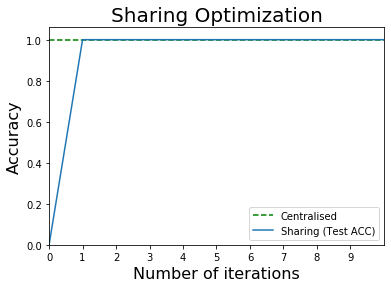

In [155]:
plt.plot(range(19), np.ones(19), 'g--', label="Centralised")
plt.plot(range(19), [acc[1] for acc in history_acc[1:20]], label="Sharing (Test ACC)")
plt.ylim(0,1.06)
plt.xlim(0, 10)
plt.xticks(range(10))
# plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel("Number of iterations", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.title("Sharing Optimization", fontsize=20)
# plt.savefig("Sharing_Accuracy1.jpg")

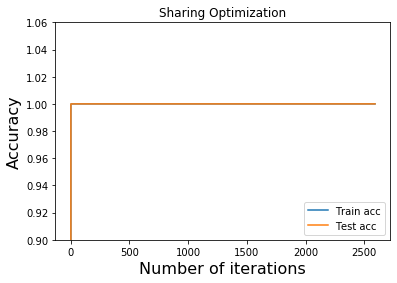

In [150]:
plt.plot(range(counter), [acc[0] for acc in history_acc], label="Train acc")
plt.plot(range(counter), [acc[1] for acc in history_acc], label="Test acc")
plt.ylim(0.9,1.06)
# plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel("Number of iterations", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.title("Sharing Optimization")
plt.savefig("Sharing_Accuracy.jpg")

## Centralised version

In [45]:
import cvxpy as cp

In [46]:
m, n = X_train.shape

x = cp.Variable((n+1, 1))
lambd = cp.Parameter(nonneg=True)
loss = cp.sum(cp.pos(1 + A_train*x))
reg = cp.sum_squares(x)
prob = cp.Problem(cp.Minimize(loss + lambd*reg))

lambd.value = 10

prob.solve(verbose=True, solver='ECOS')


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +8.425e+03  +7.020e+04  +9e+05  8e-01  2e+01  1e+00  2e+01    ---    ---    2  1  - |  -  - 
 1  +9.588e+03  +6.882e+04  +9e+05  8e-01  2e+01  2e+00  2e+01  0.0270  9e-01   1  1  1 |  0  0
 2  +1.111e+04  +6.687e+04  +8e+05  8e-01  8e+00  8e+00  2e+01  0.1421  8e-01   2  1  2 |  0  0
 3  +1.470e+04  +4.346e+04  +7e+05  4e-01  3e+00  3e+01  2e+01  0.3319  5e-01   3  2  2 |  0  0
 4  +1.485e+04  +4.169e+04  +7e+05  4e-01  3e+00  3e+01  2e+01  0.0505  6e-01   3  2  2 |  0  0
 5  +1.498e+04  +4.120e+04  +7e+05  4e-01  3e+00  3e+01  2e+01  0.0572  9e-01   2  2  2 |  0  0
 6  +1.585e+04  +2.102e+04  +3e+05  7e-02  3e-01  3e+01  6e+00  0.7529  2e-01   3  1  2 |  0  0
 7  +1.600e+04  +1.877e+04  +2e+05  4e-02  1e-01  2e+01  4e+00  0.4482  7e-02   3  2  2 |  0  0
 8  +1.598e+04  +1.837e+04  +1e+05  3e-02  1e-

15903.960710156014

In [47]:
y_pred_tr = np.sign(A_train.dot(x.value))
y_pred_te = np.sign(A_test.dot(x.value))

# train_error = (y_train != y_pred_tr).sum()/len(y_train)
# test_error = (y_test != y_pred_te).sum()/len(y_test)

train_acc = accuracy_score(y_train, y_pred_tr)
test_acc = accuracy_score(y_test, y_pred_te)

print("train\n", confusion_matrix(y_train, y_pred_tr))
print("\ntest\n", confusion_matrix(y_test, y_pred_te))

print("\nACC: \ntrain = {}, \ntest {}".format(train_acc, test_acc))


train
 [[13985     0]
 [    0  7949]]

test
 [[6015    0]
 [   0 3386]]

ACC: 
train = 1.0, 
test 1.0


In [151]:
xx = np.concatenate(FC.x_chunks)
for i in range(len(xx)):
    print(x.value[i], xx[i])

[0.05337571] [0.05053213]
[-0.02180852] [-0.02598058]
[0.08543553] [0.08583012]
[0.01439653] [0.01360214]
[0.00692604] [0.00925495]
[0.00878857] [0.00850372]
[0.02572417] [0.02617368]
[-0.02407003] [-0.02465562]
[-0.00363048] [-0.00654396]
[0.00504717] [0.00552111]
[-0.00288356] [-0.00291164]
[-0.00214488] [-0.00189806]
[-0.04316751] [-0.04603868]
[-0.00501182] [-0.00430932]
[-0.01512126] [-0.01369751]
[-0.00948289] [-0.01498963]
[-0.09411324] [-0.09433581]
[-0.05075451] [-0.0502183]
[-0.01028975] [-0.01219326]
[0.39874052] [0.39963155]
[-0.0027272] [-0.00391742]
[0.25670447] [0.26042908]
[-0.01345056] [-0.01330954]
[-0.03122118] [-0.03094633]
[-0.00320901] [-0.00485512]
[-0.00027402] [-0.00027402]
[-0.00134614] [-0.00137149]
[0.00042656] [0.00042656]
[0.01231456] [0.01184222]
[-0.0728825] [-0.07493847]
[0.01149359] [0.01268921]
[0.00604528] [0.00604527]
[-0.02758201] [-0.02681918]
[-0.02396133] [-0.02383815]
[-0.00725142] [-0.00756803]
[-0.00421661] [-0.00457127]
[-0.00585107] [-0.005

In [598]:
# FC.x_chunks